In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import *

In [2]:
ls /home/wootaekim/work/data/amore/AMoRE1/test/

AMORECONT_000035.h5.00550  AMORECONT_000035.h5.00553  AMORECONT_000035.h5.00556
AMORECONT_000035.h5.00551  AMORECONT_000035.h5.00554  AMORECONT_000035.h5.00557
AMORECONT_000035.h5.00552  AMORECONT_000035.h5.00555  AMORECONT_000035.h5.00570


In [2]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
'''butterworth'''
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low, high], btype='band')
    return b,a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5) :
    b,a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b,a,data)
    return y

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [5]:
def TRG(array, thr) :
    ## Array - thresold
    ad = array-thr
    
    ## 1st trigger
    n_trg1 = np.prod([ad[1:], ad[:-1]],axis=0)          
    trg1 = (n_trg1 < 0)
    trg1 = np.append(trg1, False)

    ## 2nd trigger
    n_trg2 = np.diff(array)
    n_trg2 = np.append(n_trg2, 0)
    trg2 = (n_trg2 > thr*0.01)
    
    ## Finial trigger
    trgf = np.all([trg1, trg2], axis=0)
    
    #plt.plot(array)
    #plt.show()
    #plt.plot(trg1,'ro', markersize=0.1)
    #plt.plot(trg2, 'bo', markersize=0.1)
    #plt.plot(trgf, 'rX')

    #plt.show()
    
    return np.where(trgf==True)

In [6]:
lowcut = 200
highcut = 500
fs = 100e+3
order = 1

Keys : KeysView(<HDF5 file "amorecont_20201104_1913.h5.00098" (mode r)>)
['rawdata']
{'names':['chunkno','time','adc'], 'formats':['<i4',('<u8', (1,)),('<u4', (1, 16, 32768))], 'offsets':[0,8,16], 'itemsize':2097168}
(1831,)
total global channel :  48
2020-11-05 17:32:26.279436



0
1
2
3


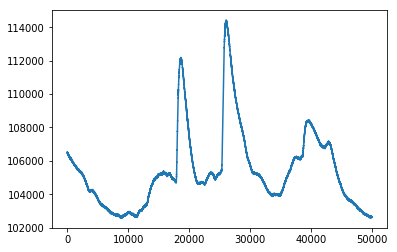

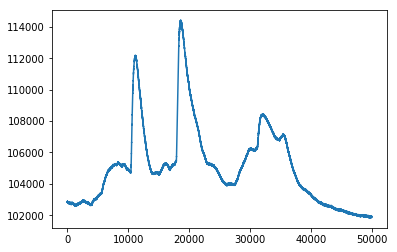


0
1
2
3

0
1
2
3


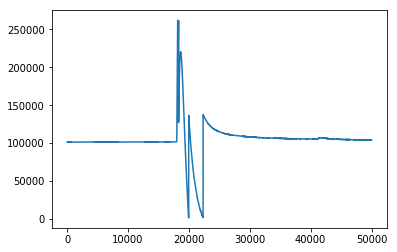

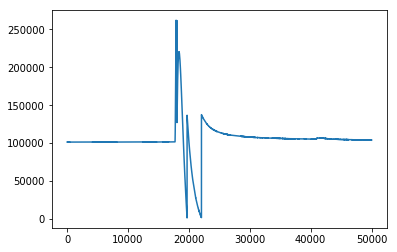

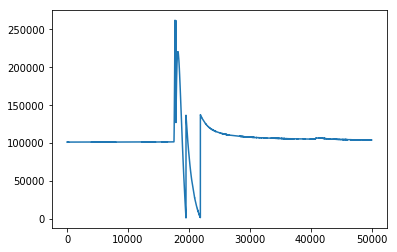

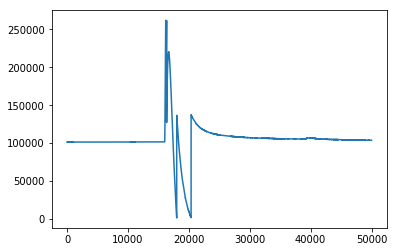

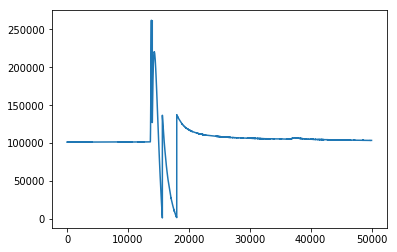

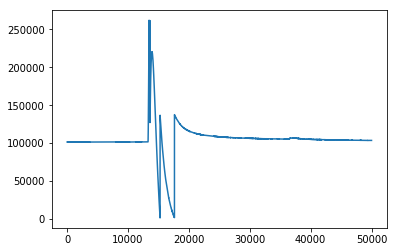


0
1
2
3


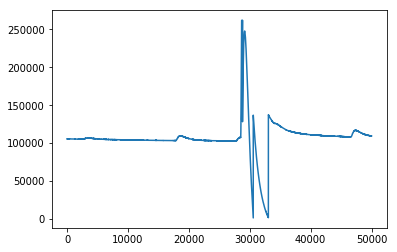


0
1
2
3


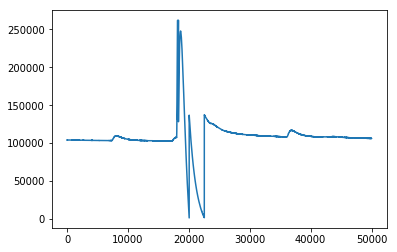

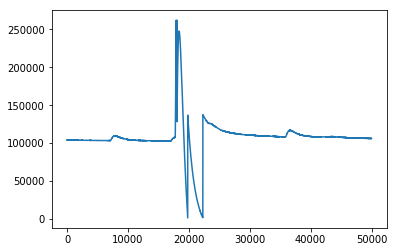

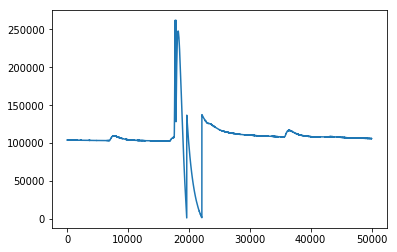

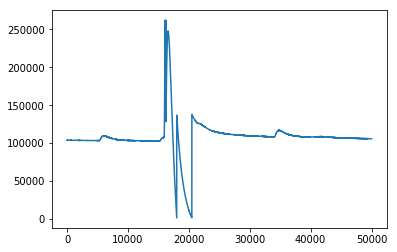

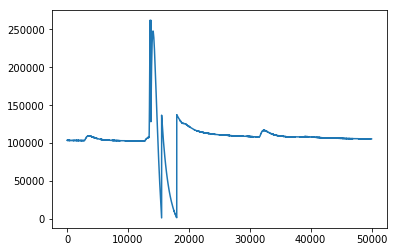

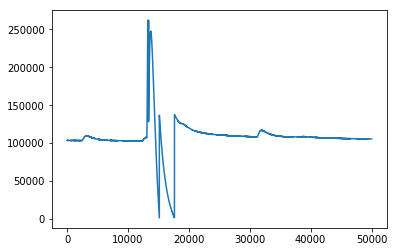

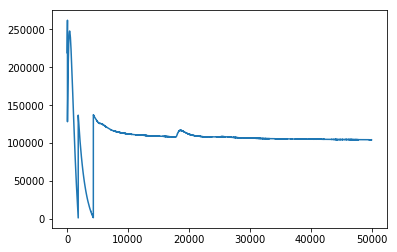


0
1
2
3

0


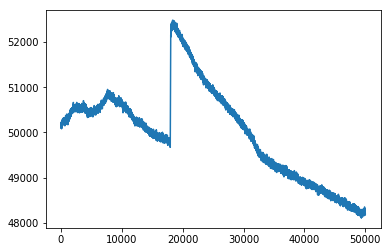

1
2
3


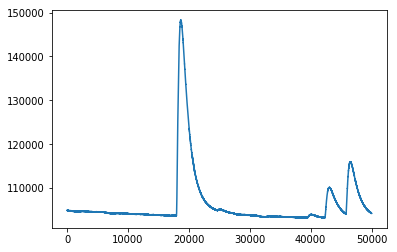

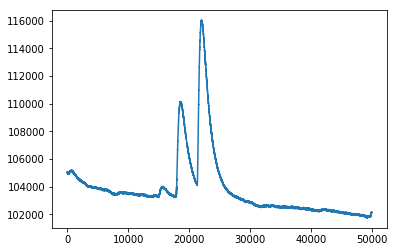

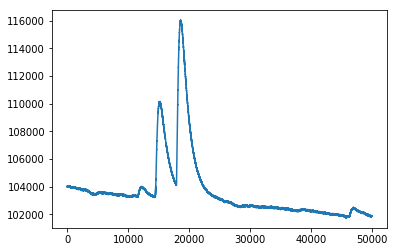


0
1
2
3

0
1
2
3

0
1
2
3


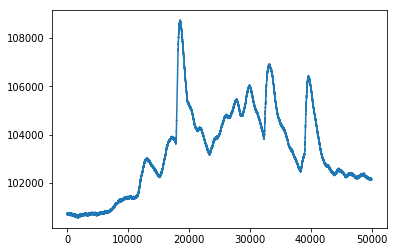


0
1
2
3


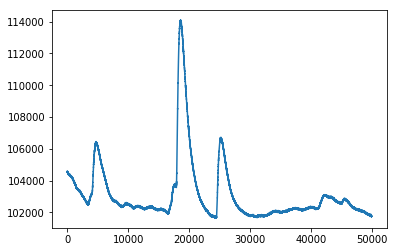

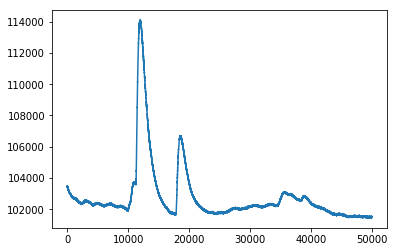


0
1
2
3


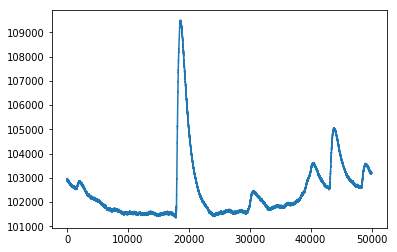


0
1
2
3


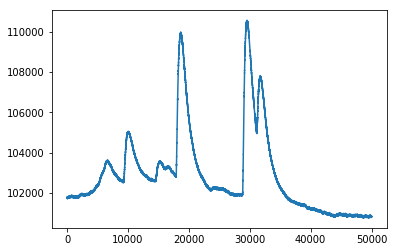


0
1
2
3


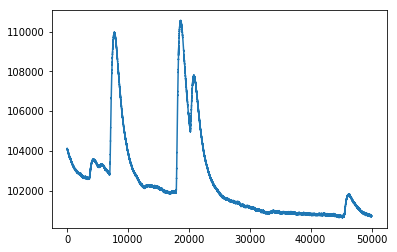


0
1
2
3


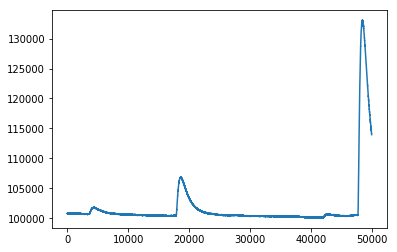


0
1
2
3


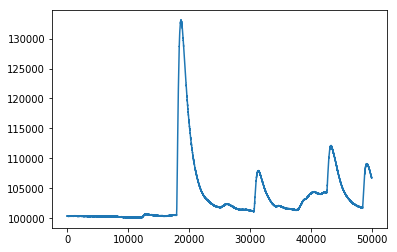

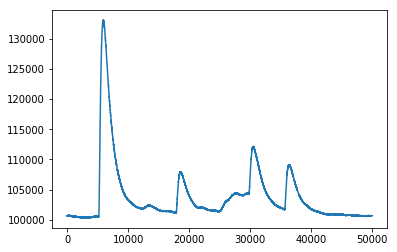


0
1
2
3


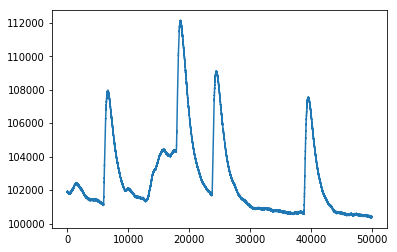

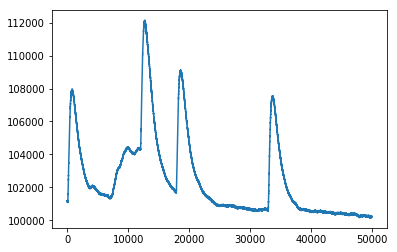

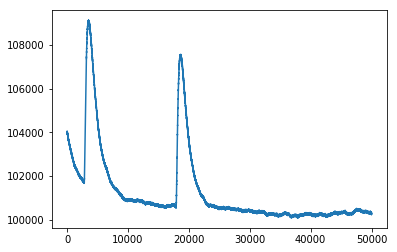


0
1
2
3


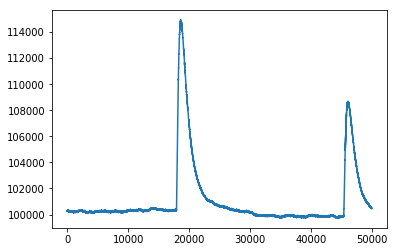


0
1
2
3


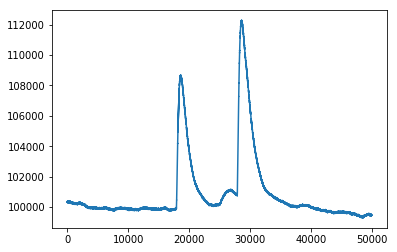


0


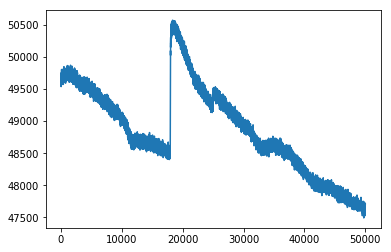

1
2
3


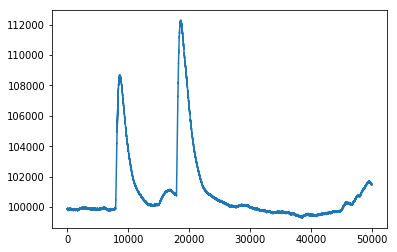


0
1
2
3


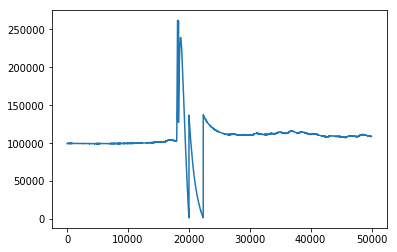

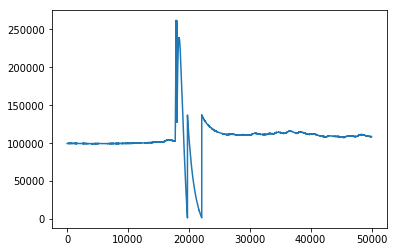

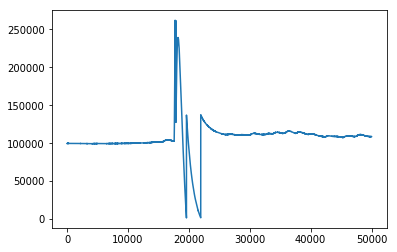

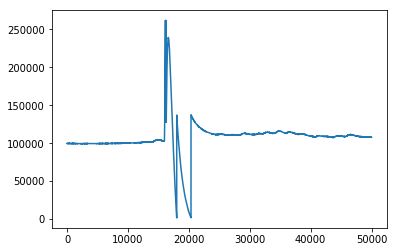

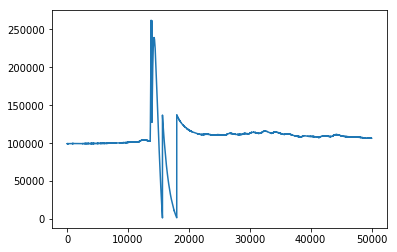

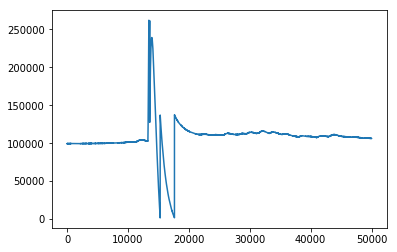


0
1
2
3


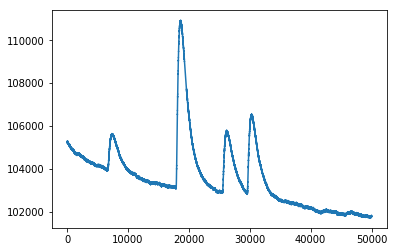


0
1
2
3

0
1
2
3

0
1
2
3


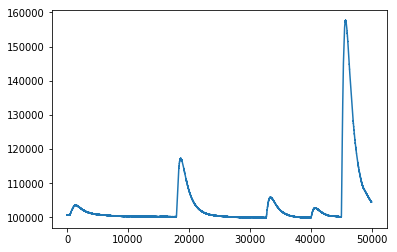

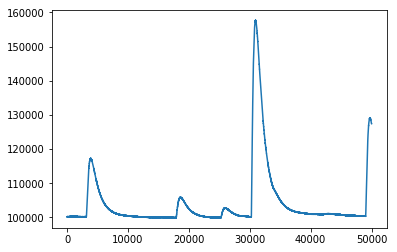


0
1
2
3


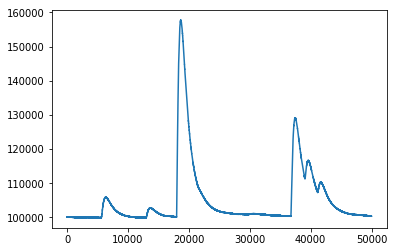

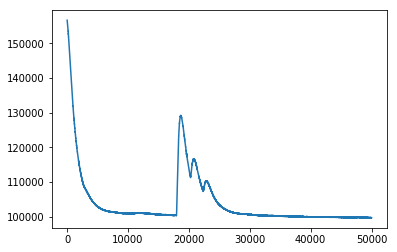

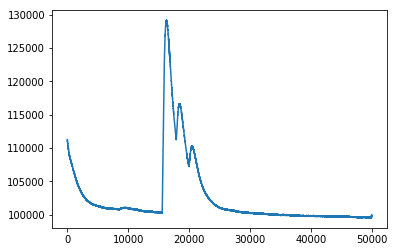


0
1
2
3


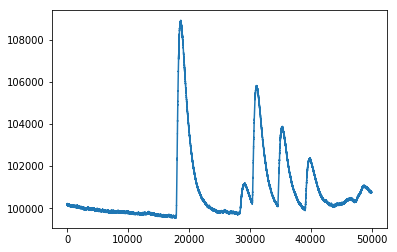


0
1
2
3


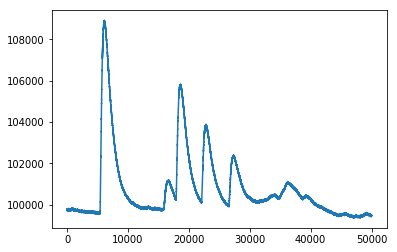


0
1
2
3


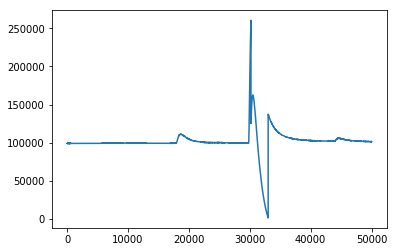


0


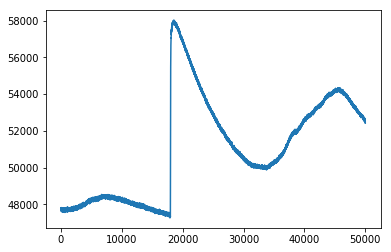

1
2
3


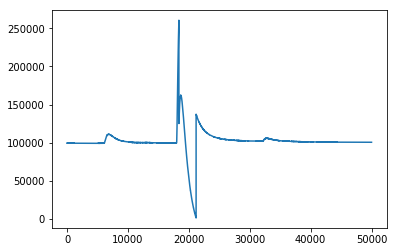

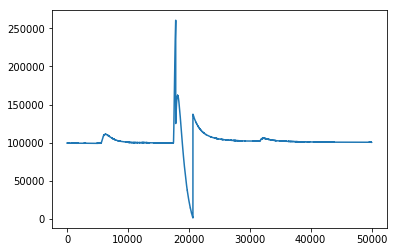

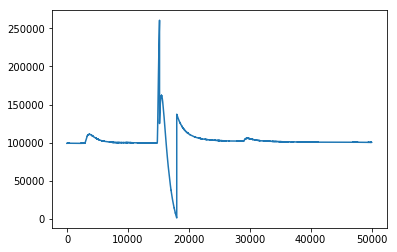

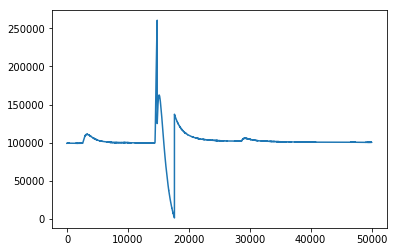

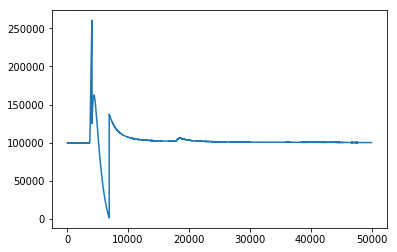


0
1
2
3

0
1
2
3


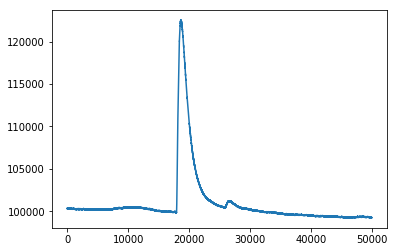


0
1
2
3


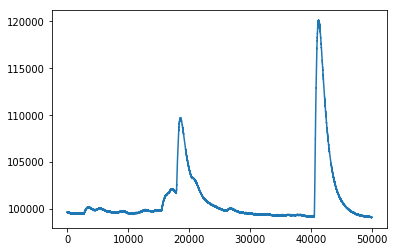


0
1
2
3


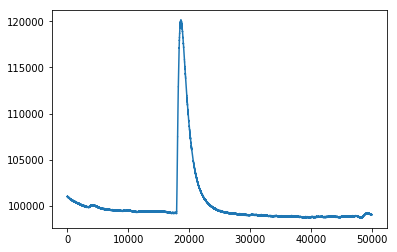


0
1
2
3

0
1
2
3

0
1
2
3


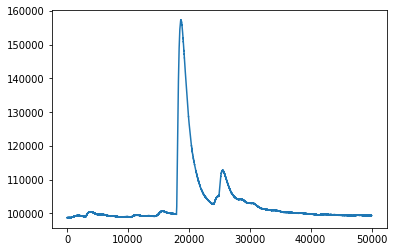


0
1
2
3


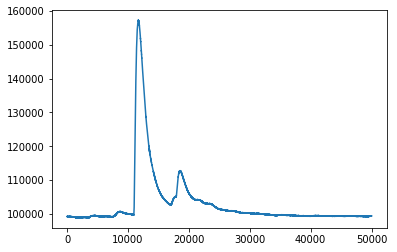


0
1
2
3


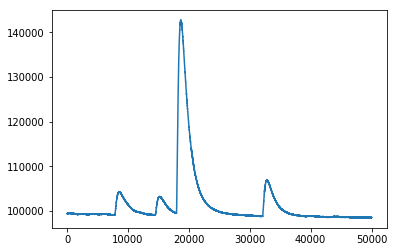


0
1
2
3


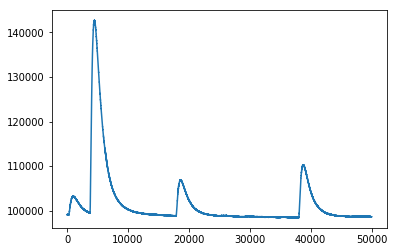

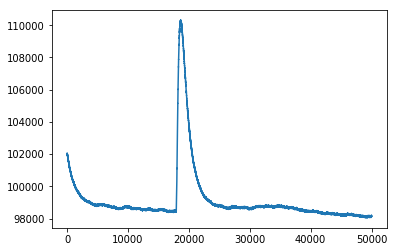


0
1
2
3

0
1
2
3


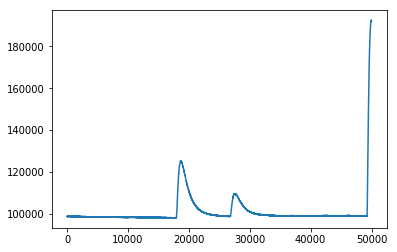

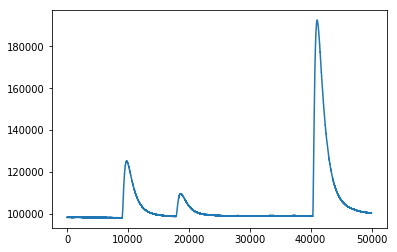


0
1
2
3


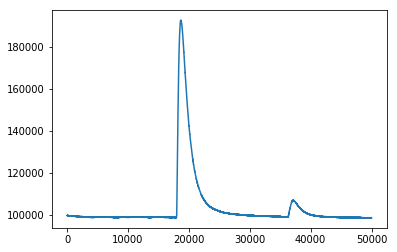

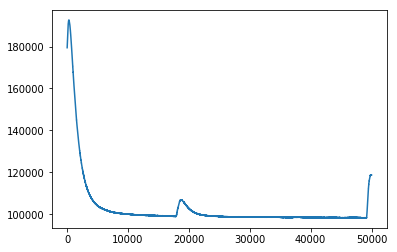


0
1
2
3


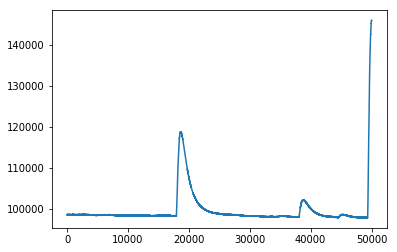


0
1
2
3


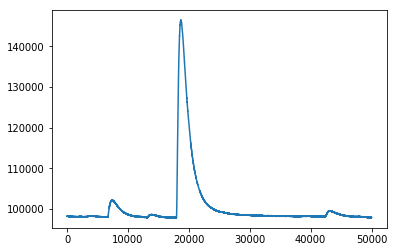

KeyboardInterrupt: 

In [24]:
fs = 100e+3
order = 1
init = 18000
fini = 32000
thr = 0 # peak finder (simple)
THR = 4000 # Trigger
import datetime
a = datetime.datetime.now()

with h5py.File('/data/AMoRE/users/kimwootae/RAW/2020_2nd_RODY/20201104/amorecont_20201104_1913.h5.00098', 'r') as f :
    print ("Keys : %s" % f.keys())
    print (list(f.keys()))

    dset = f['rawdata']
    print (dset.dtype)
    print (dset.shape)
    
    mod = 3
    lch = 16
    gch = mod*lch
    print ("total global channel : ", gch)
    
    ladc = [[] for _ in range(lch)]
    gadc = [[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]] for _ in range(mod)]
    
    evt = [[[0], [0], []]] # [[evtnumber], [ch], [time], [adc]]

    for i in range(int(dset.shape[0])) :
        data = np.array(dset[i][2])
        tt = np.array(dset[i][1])
        if ((i == 0) or (i%100)==0) :
            print (datetime.datetime.now())
        
        for j in range(0,1) :
            
            for k in range(0, 4, 1) :
                y = np.array(data[j][k])
                gadc[j][k].append(y)
            
                if (len(gadc[j][k]) <= 3) :
                    continue
                if (len(gadc[j][k]) > 3) : 
                    del gadc[j][k][0]
                
                ### RAW data arry
                yy = np.array(np.reshape(gadc[j][k], -1)).astype('int')
                
                yyx = np.array(yy[32768:65536])
                ### butterworth bandpass filtering
                yyy = butter_bandpass_filter(yyx-yyx[0], lowcut, highcut, fs, order=1)

                testx = TRG(yyy, 500)
                print (k)
                for ii in (testx[0]) :
                    y1 = yy[ii+int(32768)-init:ii+int(32768)+fini]
                    yxx = butter_bandpass_filter(y1-y1[0], lowcut, highcut, fs, order=1)
                    plt.plot(y1)
                    #plt.xlim(17500, 18500)
                    plt.show()
           
            aa = input()
            if (aa == 'q') :
                break
                
               
        
b = datetime.datetime.now()
print (b-a)

In [25]:
for k in range(1, 4, 2) :
    print (k)

1
3


In [26]:
fs = 100e+3
order = 1
init = 18000
fini = 32000
thr = 0 # peak finder (simple)
THR = 4000 # Trigger
import datetime
a = datetime.datetime.now()

with h5py.File('/data/AMoRE/users/kimwootae/RAW/2020_2nd_RODY/20201104/amorecont_20201104_1913.h5.00098', 'r') as f :
    print ("Keys : %s" % f.keys())
    print (list(f.keys()))

    dset = f['rawdata']
    print (dset.dtype)
    print (dset.shape)
    
    mod = 3
    lch = 16
    gch = mod*lch
    print ("total global channel : ", gch)
    
    test_array = []
    for i in range(int(dset.shape[0])) :
        data = np.array(dset[i][2])
        tt = np.array(dset[i][1])
        if ((i == 0) or (i%100)==0) :
            print (datetime.datetime.now())
        y = np.array(data[j][3])
        test_array.append(y)
                
yy = np.array(np.reshape(test_array, -1)).astype('int')   

Keys : KeysView(<HDF5 file "amorecont_20201104_1913.h5.00098" (mode r)>)
['rawdata']
{'names':['chunkno','time','adc'], 'formats':['<i4',('<u8', (1,)),('<u4', (1, 16, 32768))], 'offsets':[0,8,16], 'itemsize':2097168}
(1831,)
total global channel :  48
2020-11-05 17:34:21.768961
2020-11-05 17:34:22.914907
2020-11-05 17:34:24.212073
2020-11-05 17:34:25.458055
2020-11-05 17:34:26.728547
2020-11-05 17:34:28.131938
2020-11-05 17:34:29.622115
2020-11-05 17:34:31.183087
2020-11-05 17:34:32.519623
2020-11-05 17:34:33.750850
2020-11-05 17:34:35.097878
2020-11-05 17:34:36.343537
2020-11-05 17:34:37.557978
2020-11-05 17:34:38.777373
2020-11-05 17:34:39.980625
2020-11-05 17:34:41.316360
2020-11-05 17:34:42.774631
2020-11-05 17:34:44.093662
2020-11-05 17:34:45.386397
